In [1]:
from math import *
import numpy as np
import pandas as pd
import sys
from sys import stdout as cout
from CFLib.timer import Timer
from CFLib.heston_evol import heston_trj
from CFLib.stats import stats
from CFLib.Heston import Heston
from CFLib.FT_opt import ft_opt
from CFLib.euro_opt import impVolFromFwPut
from CFLib.euro_opt import impVolFromFwCall
from scipy.stats import norm
import matplotlib.pyplot as plt

## Monte Carlo

In [2]:
So = 1
r = 0
q = 0
Strikes = [0.8,0.9,0.95,0.975,1.0,1.025,1.1,1.2]
t = [1/12,2/12,3/12,6/12,1.0,1.5]
lmbda = 7.7648
eta = 2.0170
nubar = 0.0601
nu_o = 0.0475
rho = -0.6952
Yrs = 1.5  # length of the trajectory in years
Nt = int(360*Yrs)  # number of steps in the S trajectory
dt = Yrs/Nt  # step per vol integration
NV = 1000  # number of vol trajectories
NS = 1000  # number of S trajectory per vol trajectory

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err        elapsed
        0    1.000000      0.00e+00        0.00e+00     0.1707 sec.
       30    0.998938      1.06e-03        2.41e-03     0.1667 sec.
       60    0.999134      8.66e-04        3.29e-03     0.6089 sec.
       90    0.998482      1.52e-03        3.97e-03     0.1560 sec.
      120    1.000606      6.06e-04        4.50e-03     0.1382 sec.
      150    0.999801      1.99e-04        5.19e-03     0.1300 sec.
      180    0.999856      1.44e-04        5.54e-03     0.1430 sec.
      210    1.000639      6.39e-04        5.88e-03     0.1338 sec.
      240    1.001655      1.66e-03        6.34e-03     0.1460 sec.
      270    1.004113      4.11e-03        6.60e-03     0.1352 sec.
      300    1.002605      2.61e-03        7.05e-03     0.1552 sec.
      330    1.001972      1.97e-03        7.34e-03     0.2487 sec.
      360    0.999414      5.86e-04        7.71e-03     0.2352 sec.
      390    1.000019      1.85e-05        8.00e-0

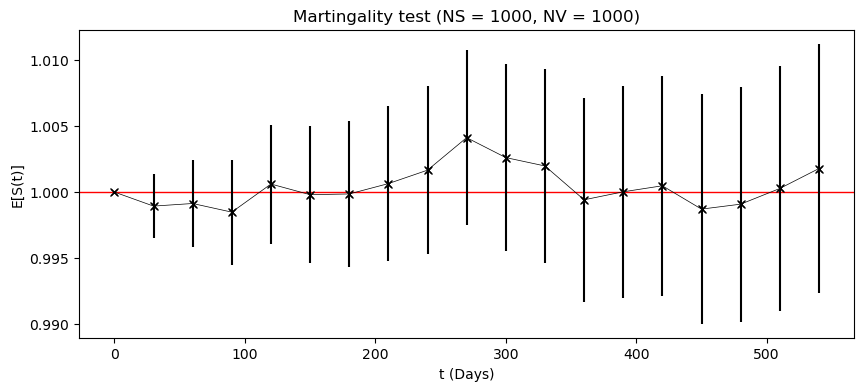

In [3]:
def martingale_property(So, lmbda, eta, nubar, nu_o, rho, Yrs, dt, Nt, NV, NS):
    
    cout.write("%9s    %8s   %8s    %8s   %12s\n" %("t", "E[S(t)]", "|S(0)-E[S(t)]|", "MC-err", "elapsed"))
    T1 = Timer()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axhline(y=1, color='red', linestyle='-', linewidth=1)
    E_values = [] 
    
    Rand = np.random.RandomState()
    Rand.seed(29284)
    S_t = heston_trj(Rand, So, lmbda, eta, nubar, nu_o, rho, Yrs, dt, Nt, NV, NS)
    m_c = np.zeros((19, NV))
    s_c = np.zeros((19, NV))
    E = np.zeros((19, 1))
    std = np.zeros((19, 1))

    for j, i in enumerate([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540]):
        T1.start()
        for nv in range(len(S_t)):
            m_c[j][nv], s_c[j][nv] = stats(S_t[nv][i][:])
            
        E[j], std[j] = stats(m_c[j])
        Err = 1.65 * std[j] / sqrt(NV)
                
        t1 = T1.stop()
        cout.write("%9s    %8.6f      %8.2e        %8.2e   %8.4f sec.\n" %(i, E[j][0], abs(1 - E[j][0]), Err[0], t1))
    
        ax.errorbar(i, E[j][0], yerr=Err[0], fmt='x', color='black', markersize=5)  
        E_values.append(E[j][0])  
    
    ax.plot([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540], E_values, marker='x', color='black', linestyle='-', linewidth=0.5)
            
    ax.set_xlabel('t (Days)')
    ax.set_ylabel('E[S(t)]')
    ax.set_title('Martingality test (NS = {}, NV = {})'.format(NS,NV))
    ax.grid(False)
    plt.show()

martingale_property(So, lmbda, eta, nubar, nu_o, rho, Yrs, dt, Nt, NV, NS)

In [4]:
def price_cf_MC(So, lmbda, eta, nubar, nu_o,rho,Yrs, dt,Nt,NV,NS,K,r):
    
    Rand = np.random.RandomState()
    Rand.seed(29284)
    S = heston_trj(Rand,So, lmbda, eta, nubar, nu_o,rho,Yrs, dt,Nt,NV,NS)
    m_c = np.zeros((6,NV))
    s_c = np.zeros((6,NV))
    price_c = np.zeros((6,1))
    std_c = np.zeros((6,1))
    error_c = np.zeros((6,1))
    price_p = np.zeros((6,1))
    
    j = 0 
    for i in [30,60,90,180,360,540]:
        for nv in range(len(S)):
            payoff_c = np.where(S[nv][i][:]>K,S[nv][i][:]-K,0)
            m_c[j][nv],s_c[j][nv] = stats(payoff_c)
             
        price_c[j], std_c[j] = stats(m_c[j])
        price_c[j] = price_c[j] * exp(-r * i*dt)
        error_c[j] = 1.65 * std_c[j] / sqrt(NV)
        price_p[j] = price_c[j] + (K-1)
        j += 1 
    
    return price_c,price_p,error_c   

In [5]:
CALL = np.zeros((6,len(Strikes)))
PUT = np.zeros((6,len(Strikes)))
pERR = np.zeros((6,len(Strikes)))
for i in range(len(Strikes)):
    c,p,e = price_cf_MC(So, lmbda, eta, nubar, nu_o,rho,Yrs, dt,Nt,NV,NS,Strikes[i],r)
    CALL[:,i],PUT[:,i],pERR[:,i] = c[:,0],p[:,0],e[:,0]


## Fourier 

In [6]:
def np_pricer(model, So,r, qy, strikes, T, Xc=1.0):
    
    Out = dict()
    if isinstance(strikes, list):
        vStrikes = np.array(strikes)
    else:
        vStrikes = strikes
    
    for t in T:
        Fw = So * exp((r-qy)*t)
        xc = Xc**sqrt(t)
        
        vKT = (vStrikes/Fw)
        Out[t] = ft_opt(model, vKT, t, xc)
        Out[t]['put'] *= So * exp(-qy*t)
        Out[t]['call'] *= So * exp(-qy*t)
        Out[t]['pAn'] *= So * exp(-qy*t)
        Out[t]['Strike'] = vStrikes
    
    return Out
        

In [7]:
model = Heston(lmbda=lmbda, nubar=nubar, eta=eta, nu_o=nu_o, rho=rho)

In [8]:
for i in range(len(Strikes)):
    
    Out = np_pricer(model,So,r,q,[Strikes[i]],t,Xc = 5.)
    print("\n%5s    %6s%4s   %7s %7s       %6s  %7s  %7s" %("So","Strike", "t", "Put","Call", "Err", "ftPut","ftCall"))
    
    for x,y,c,z in zip(t,PUT,CALL,pERR):

        put = Out[x]["put"]
        call = Out[x]["call"]
        print("%6.3f  %6.3f %6.3f  %7.4f %7.4f  +/-  %7.1e %7.4f %7.4f" %(So, Strikes[i], x,y[i],c[i],z[i],put,call)) 


   So    Strike   t       Put    Call          Err    ftPut   ftCall
 1.000   0.800  0.083   0.0001  0.2001  +/-  2.2e-03  0.0009  0.2009
 1.000   0.800  0.167   0.0028  0.2028  +/-  2.6e-03  0.0033  0.2033
 1.000   0.800  0.250   0.0047  0.2047  +/-  2.9e-03  0.0058  0.2058
 1.000   0.800  0.500   0.0133  0.2133  +/-  3.7e-03  0.0131  0.2131
 1.000   0.800  1.000   0.0256  0.2256  +/-  4.9e-03  0.0266  0.2266
 1.000   0.800  1.500   0.0404  0.2404  +/-  5.9e-03  0.0391  0.2391

   So    Strike   t       Put    Call          Err    ftPut   ftCall
 1.000   0.900  0.083   0.0042  0.1042  +/-  1.6e-03  0.0045  0.1045
 1.000   0.900  0.167   0.0095  0.1095  +/-  1.8e-03  0.0099  0.1099
 1.000   0.900  0.250   0.0138  0.1138  +/-  2.0e-03  0.0146  0.1146
 1.000   0.900  0.500   0.0271  0.1271  +/-  2.6e-03  0.0271  0.1271
 1.000   0.900  1.000   0.0468  0.1468  +/-  3.7e-03  0.0480  0.1480
 1.000   0.900  1.500   0.0663  0.1663  +/-  4.6e-03  0.0656  0.1656

   So    Strike   t       Put  

Implied volatilities:


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.284211  0.294172  0.246697  0.218598  0.188976  0.163377  0.162262  0.194917
2M   0.340093  0.270764  0.229914  0.208284  0.186539   0.16689  0.151694  0.176373
3M   0.310802  0.254672  0.222413  0.205581  0.188816  0.173218  0.151058  0.164268
6M   0.293451  0.244121  0.220433  0.208979  0.197959  0.187618  0.163692  0.154906
1Y   0.262087  0.232691  0.219055   0.21251  0.206182  0.200105  0.183812   0.16829
18M  0.260148  0.235981  0.225081  0.219922  0.214974  0.210227  0.197212  0.182982




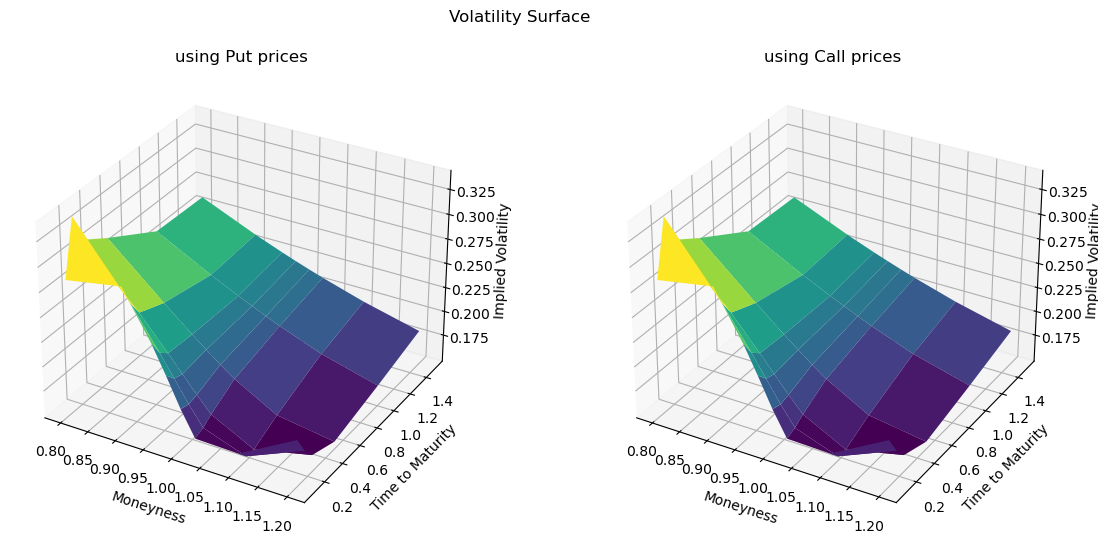

In [9]:
t1 = ['1M','2M','3M','6M','1Y','18M']
prices1 = np.zeros((6,len(Strikes)))
vol1 = np.zeros((6,len(Strikes)))
prices2 = np.zeros((6,len(Strikes)))
vol2 = np.zeros((6,len(Strikes)))

for i in range(len(Strikes)):
    prices1[:,i] = price_cf_MC(So, lmbda, eta, nubar, nu_o,rho,Yrs, dt,Nt,NV,NS,Strikes[i],r)[1][:,0]
    prices2[:,i] = price_cf_MC(So, lmbda, eta, nubar, nu_o,rho,Yrs, dt,Nt,NV,NS,Strikes[i],r)[0][:,0]
    
for i in range(len(Strikes)):
    for j in range(6):
        vol1[j,i] = impVolFromFwPut(prices1[j,i], t[j], Strikes[i]) 
        vol2[j,i] = impVolFromFwCall(prices2[j,i], t[j], Strikes[i]) 

dfVol = pd.DataFrame(index=t1, columns=Strikes)
for i in range(len(t)):
    dfVol.iloc[i] = vol1[i].tolist()
            
print('Implied volatilities:')
print('\n')
print(dfVol.to_string())
print('\n')

X, Y = np.meshgrid(Strikes,t)
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, vol1, cmap='viridis')
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('using Put prices')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, vol2, cmap='viridis')
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('using Call prices')
fig.suptitle('Volatility Surface')
plt.show()

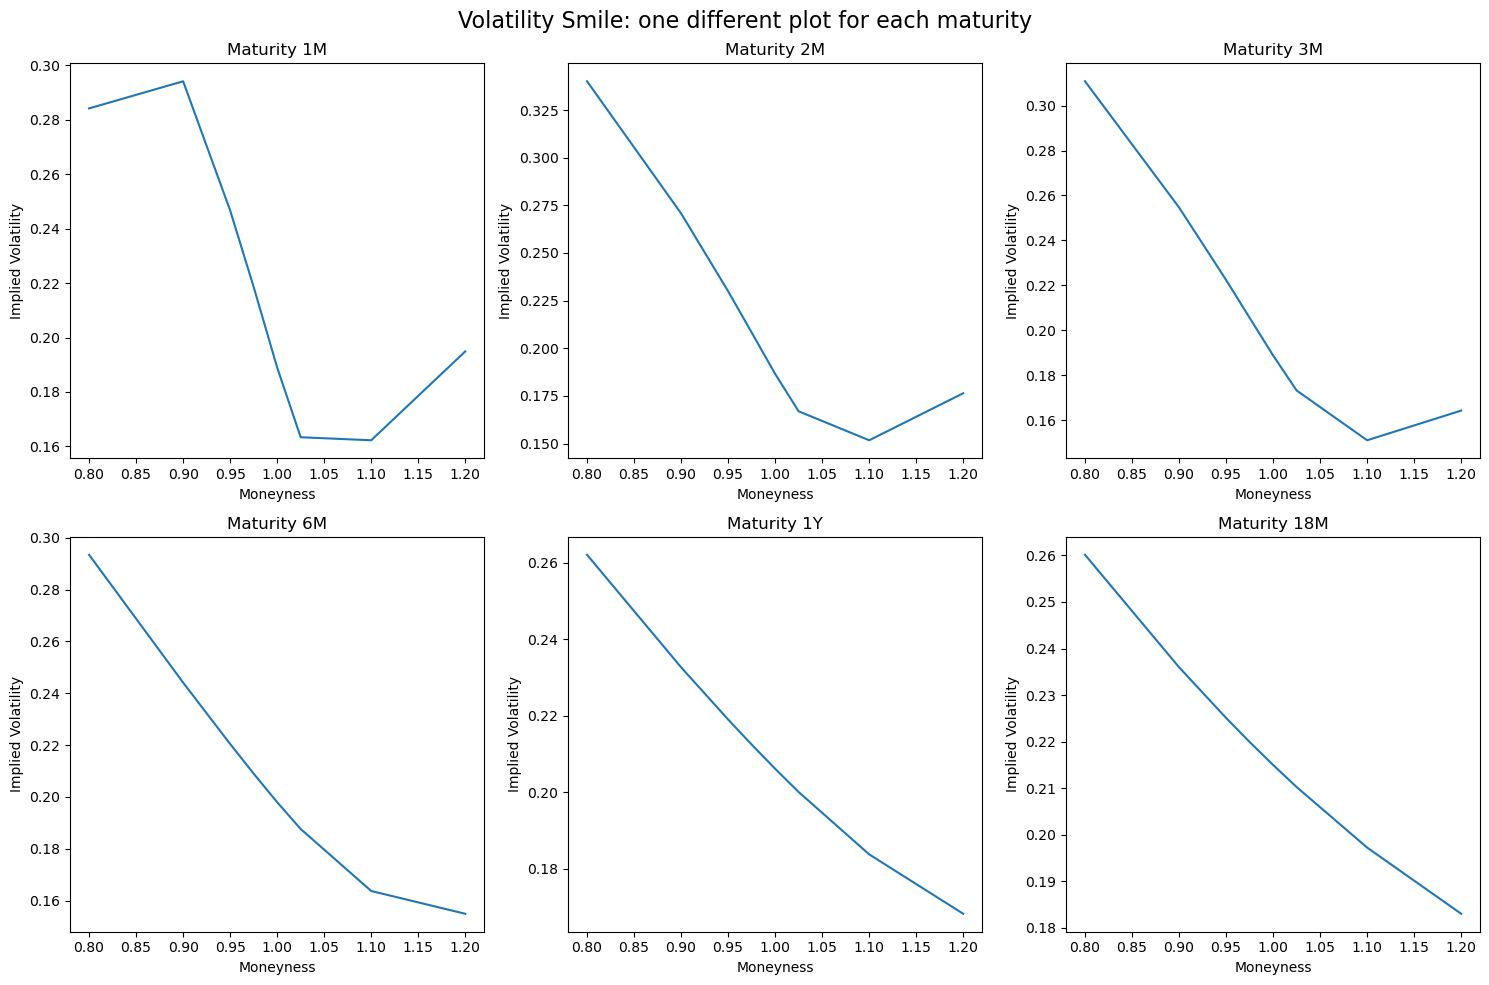

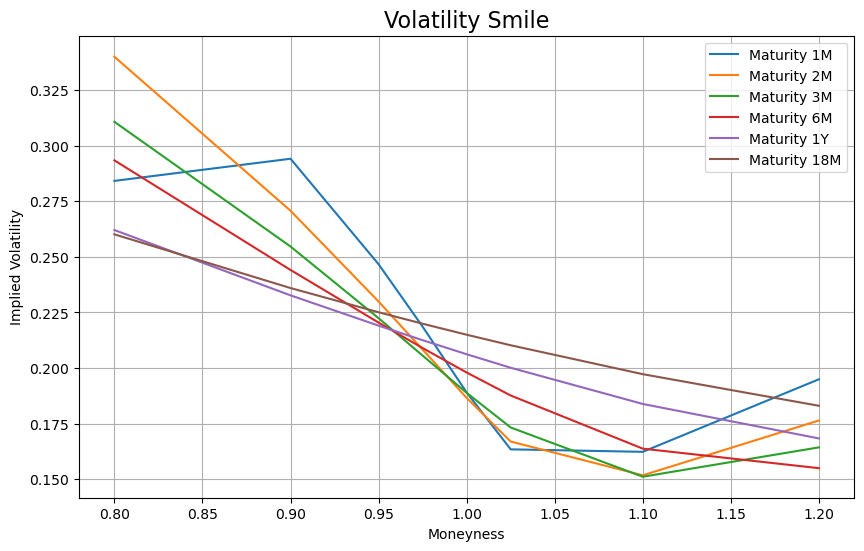

In [10]:
# volatility smile: one different plot for each maturity
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(Strikes, vol1[i])
    ax.set_title(f'Maturity {t1[i]}')
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Implied Volatility')
    ax.grid(False)

fig.suptitle('Volatility Smile: one different plot for each maturity', fontsize=16)
plt.tight_layout()
plt.show()


# volatility smile: one plot with all the maturities
plt.figure(figsize=(10, 6))
for i in range(len(t)):
    plt.plot(Strikes, vol1[i], label=f'Maturity {t1[i]}')
plt.title('Volatility Smile', fontsize=16)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.show() 